# What is a Beta-VAE?

A Beta-VAE is a variant of the VAE that introduces a scaling factor, β (beta), to the KL divergence term in the VAE loss function. This parameter controls the trade-off between reconstruction accuracy and latent space disentanglement.
# The Purpose of Beta in Beta-VAE

In a standard VAE, the loss function is defined as:
Loss=Reconstruction Loss+KL Divergence
Loss=Reconstruction Loss+KL Divergence

For a Beta-VAE, we modify this to:
Loss=Reconstruction Loss+β⋅KL Divergence
Loss=Reconstruction Loss+β⋅KL Divergence

By tuning the beta value:

    Small Beta (close to 1): The Beta-VAE behaves like a standard VAE, focusing on reconstructing images accurately but with limited disentanglement.
    Large Beta (>1): Emphasizes disentanglement, leading the latent space to represent more interpretable features but possibly at the cost of reconstruction quality.

# Disentanglement in Latent Space

Disentanglement means each dimension in the latent space represents a unique feature (such as rotation, scale, or brightness) independently of other dimensions. A disentangled latent space is beneficial for generating specific variations of an image by tweaking particular latent dimensions.

# Loss Function in Beta-VAE

The Beta-VAE loss has two components:

    Reconstruction Loss: Measures how closely the reconstructed image matches the original image.
    KL Divergence (with Beta Scaling): Controls how closely the latent space resembles a standard normal distribution, promoting smooth transitions and disentangled features.




# Implementation of Beta-VAE on MNIST Dataset

Now, let’s implement the Beta-VAE using PyTorch. We’ll train the model on the MNIST dataset.

# Step 1 : Import Libraries and Load MNIST Dataset

In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define transformations
transform = transforms.Compose([transforms.ToTensor()])

# Load Fashion MNIST dataset
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

/Users/Senjuti/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


100%|██████████| 26421880/26421880 [00:02<00:00, 10961111.49it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 212650.08it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3603654.11it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3258228.01it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# Define the Beta-VAE Model

In [3]:
# The input dimension corresponds to the flattened size of each image in the Fashion MNIST dataset.
#Flattened Dimension: 28×28=78428×28=784.
# The hidden dimension (400 in this case) is a hyperparameter that represents the number of units in the hidden layer of the encoder and decoder.
#sing a small latent_dim like 20 encourages the model to learn a compact, abstract representation of the data, which can lead to disentangled features, especially when using a Beta-VAE.

class BetaVAE(nn.Module):
    def __init__(self, input_dim = 784, hidden_dim = 400, latent_dim = 20, beta = 4):
        super(BetaVAE, self).__init__()
        self.beta = beta  # scaling factor for KL divergence

        # Encode layers 
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim) # Mean 
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim) # Log variance

        # Decode layers
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1= torch.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    def decode (self, z):
        h2 = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


        


# Define the loss function
### The Beta-VAE loss function includes a reconstruction loss and a scaled KL divergence term.


In [4]:
def beta_vae_loss(recon_x, x, mu, logvar, beta):
    # Reconstruction loss ( Binary cross-entropy)
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Total loss with beta scaling
    return recon_loss + beta * KLD

# Training the Beta-VAE Model
### Now we train the Beta-VAE on Fashion MNIST using the defined loss function.

In [5]:
# Model , optimizer and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BetaVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(data.size(0), -1).to(device) # Flatten images

        # Forward pass
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

        # Compute loss and backpropagation
        loss = beta_vae_loss(recon_batch, data, mu, logvar, beta=model.beta)
        loss.backward()
        train_loss += loss.item()
        # Update the model parameters
        optimizer.step()

    # print average loss per epoch 
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}')

Epoch 1, Average Loss: 303.0431
Epoch 2, Average Loss: 279.8501
Epoch 3, Average Loss: 275.9219
Epoch 4, Average Loss: 274.0175
Epoch 5, Average Loss: 272.8631
Epoch 6, Average Loss: 272.0004
Epoch 7, Average Loss: 271.3498
Epoch 8, Average Loss: 270.9205
Epoch 9, Average Loss: 270.5749
Epoch 10, Average Loss: 270.2000


# Visualize Distanglement in Latent Space / Visualize the Effect of Beta (Disentanglement) in Generated Images
### To visualize disentanglement, we vary each dimension of the latent vector while keeping others constant. This allows us to see how each dimension affects the generated image.

### Using a Beta-VAE (with a beta value greater than 1) encourages disentanglement in the latent space, which can help the model learn more interpretable, structured representations. This means each latent dimension in a Beta-VAE is more likely to represent a distinct feature or characteristic of the images (like rotation, thickness, or brightness), rather than a mix of multiple features. When generating images with a Beta-VAE, we benefit from:

Control Over Image Features: With a well-disentangled latent space, we can control specific features of the generated images by adjusting certain dimensions in the latent vector.

 Smooth Transitions (Interpolation): Disentanglement allows for smoother transitions and more meaningful interpolations, as each dimension tends to represent a consistent feature across different samples.





<function matplotlib.pyplot.show(close=None, block=None)>

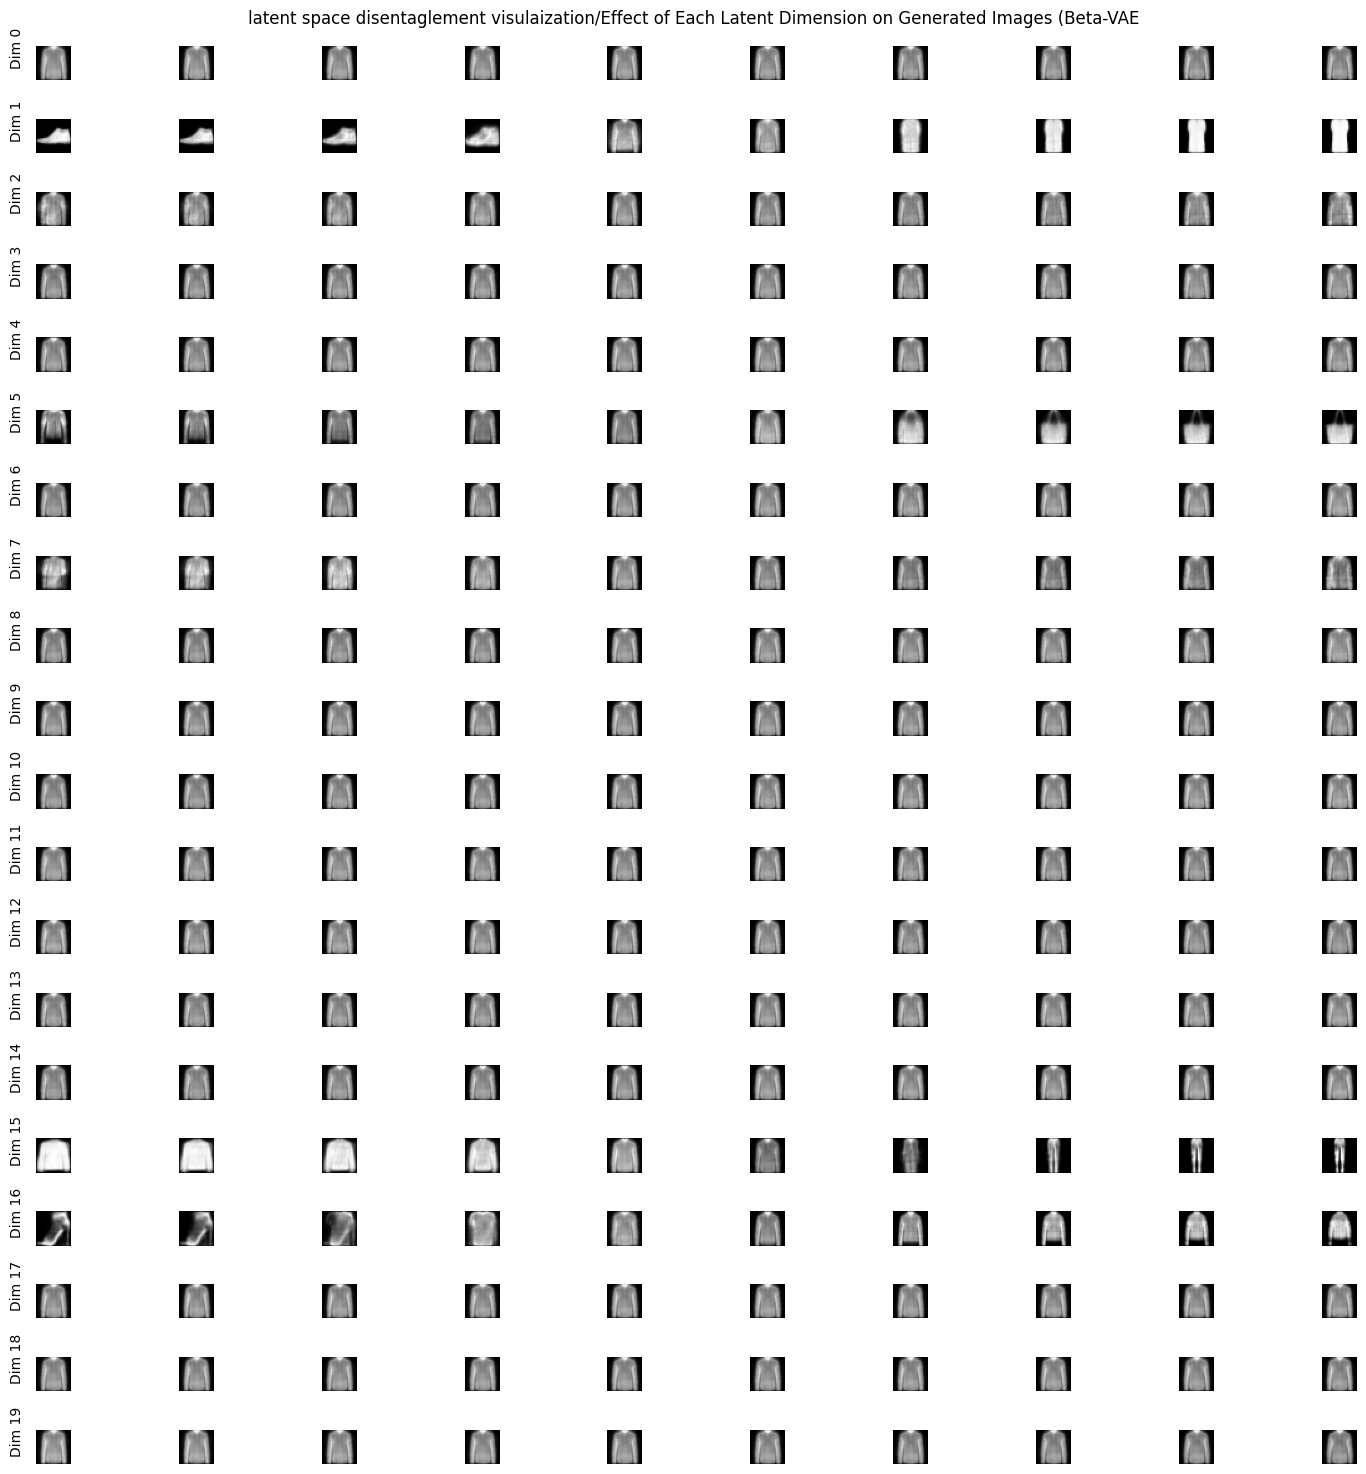

In [9]:
# Parameters for visuaization
latent_dim = 20 # Dimension of the latent space
num_variations = 10 # Number of variations per latent dimension

# Set model to evaluate mode
model.eval()

# Create a base latent vector (all zeros)
#We start with a latent vector filled with zeros for consistency, ensuring that only the dimension we vary affects the generated images
base_z = torch.zeros(latent_dim).to(device)

# range to vary each dimension
variant_range = torch.linspace(-3, 3, num_variations).to(device)

# Generate images by varying each dimension of the latent vector 
fig, axs = plt.subplots(latent_dim, num_variations, figsize=(15, 15))
plt.suptitle("latent space disentaglement visulaization/Effect of Each Latent Dimension on Generated Images (Beta-VAE")


with torch.no_grad():
    for dim in range(latent_dim):
        for i, val in enumerate(variant_range):
            # Copy the base latent vector 
            z = base_z.clone()

            # Vary only the current dimension 
            z[dim] = val

            # Decode the modified latent vecor 

            generated_image = model.decode(z.unsqueeze(0)).cpu().view(28, 28)

            # plot the genertaed image 
            axs[dim, i].imshow(generated_image, cmap='gray')
            axs[dim, i].axis('off')
        #Label each row with the corresponding latent dimension
        axs[dim, 0].text(-10, 0.5, f'Dim {dim}', rotation=90, 
                          verticalalignment='center', horizontalalignment='right')
plt.tight_layout()
plt.show

            
            

### Interpreting the Visualization
 Beta-VAE has achieved disentanglement:

    Each row in the grid represents a distinct latent dimension, showing how it independently impacts the generated images.
    Within a row, the images should change in a consistent way (such as adjusting the thickness, rotation, or type of clothing item), which indicates that this dimension has learned a specific feature.
    Higher Beta values (e.g., beta=4) typically yield clearer disentanglement, making each row more interpretable and showing the impact of changing each individual feature.

This visualization highlights the benefit of beta scaling in a Beta-VAE by showing that each latent dimension can independently control distinct features, thanks to the disentangled representation in the latent space.




# Generate new images from Beta-VAE

### Generate new images from random points in the latent space.



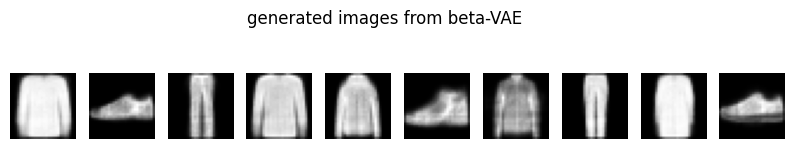

In [15]:
model.eval()

# Number of images to generate 
num_samples = 10
#This is an attribute of PyTorch’s nn.Linear layer that tells us the number of output neurons in this layer. For fc_mu, out_features is set to latent_dim
latent_dim = model.fc_mu.out_features # Dimension of the latent space

# generate random latent vectors from standard normal distribution
z = torch.randn(num_samples, latent_dim).to(device)

# decode the latent vectors to generate new images 
with torch.no_grad():
    generated_images = model.decode(z).cpu()

# plot the generated images
plt.figure(figsize=(10, 2))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(generated_images[i].view(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle("generated images from beta-VAE")
plt.show()

# Latent space interpolation 
### Interpolation between two points in the latent space to see smooth transitions between generated images

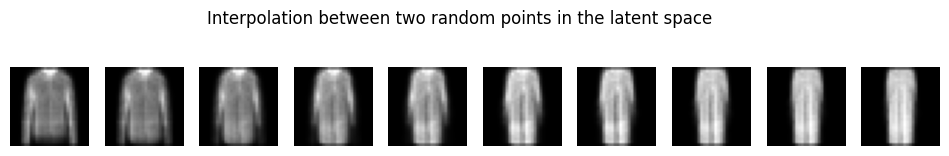

In [14]:
# Define random points in the latent space
z1 = torch.randn(1, latent_dim).to(device)
z2 = torch.randn(1, latent_dim).to(device)

# Number of steps for interpolation
### In interpolation, the number of steps defines the smoothness and granularity of the transition between two points in the latent space. This is essential because interpolation creates a sequence of points that gradually change from the starting point to the ending point, and these steps control how many intermediate points are calculated along that path.
num_steps = 10 # more steps = smmother transitions

# Create interpolation points 
interpolated_images =[]
for alpha in torch.linspace(0, 1, num_steps):
    z = (1 - alpha) * z1 + alpha * z2
    with torch.no_grad():
        generated_image = model.decode(z).cpu()
        interpolated_images.append(generated_image.cpu().view(28, 28))

# visulaize the interpolation
plt.figure(figsize=(12, 2))
for i, img in enumerate(interpolated_images):
    plt.subplot(1, num_steps, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.suptitle("Interpolation between two random points in the latent space")
plt.show()


# Interpolation using multiple points ( 3 points)

### This method is helpful in exploring complex transformations in the latent space, especially when we want to examine transitions across multiple attributes or generate images with multiple, smooth feature changes.



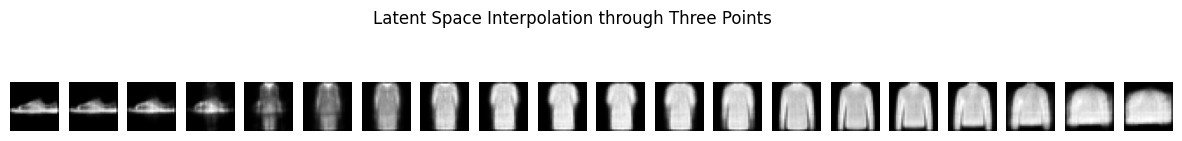

In [20]:
import torch
import matplotlib.pyplot as plt

# Define three random points in the latent space
z1 = torch.randn(1, latent_dim).to(device)
z2 = torch.randn(1, latent_dim).to(device)
z3 = torch.randn(1, latent_dim).to(device)

# Define the number of steps for each transition
num_steps = 10  # Steps from z1 to z2 and z2 to z3

# Initialize list to store images
interpolated_images = []

# Interpolate between z1 and z2
with torch.no_grad():
    for alpha in torch.linspace(0, 1, num_steps):
        z = (1 - alpha) * z1 + alpha * z2  # Linear interpolation between z1 and z2
        generated_image = model.decode(z).cpu().view(28, 28)
        interpolated_images.append(generated_image)

# Interpolate between z2 and z3
with torch.no_grad():
    for alpha in torch.linspace(0, 1, num_steps):
        z = (1 - alpha) * z2 + alpha * z3  # Linear interpolation between z2 and z3
        generated_image = model.decode(z).cpu().view(28, 28)
        interpolated_images.append(generated_image)

# Plot the interpolated images
plt.figure(figsize=(15, 2))
total_steps = len(interpolated_images)
for i, img in enumerate(interpolated_images):
    plt.subplot(1, total_steps, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.suptitle("Latent Space Interpolation through Three Points")
plt.show()
